In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


1a. MNIST using default CNN architecture 

With learning rate = 0.01


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Training hyperparameters
epochs = 1
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 0 
log_interval = 20

0it [00:00, ?it/s]

9920512it [00:01, 8585987.24it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129564.05it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 2109284.84it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


8192it [00:00, 49346.17it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!

Test set: Average loss: 6.6301, Accuracy: 838/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 7.172055
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.078102
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.614308
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.280951
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.166203
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.256819
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.117993
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.088670
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.087863
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.103475
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.057933
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.181261
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.052287
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.077905
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.266186
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.046201
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.205231
Train Epoch

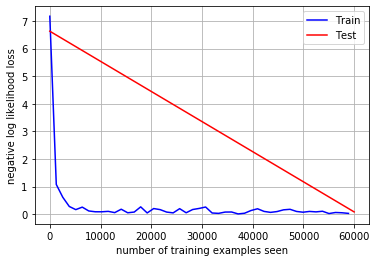

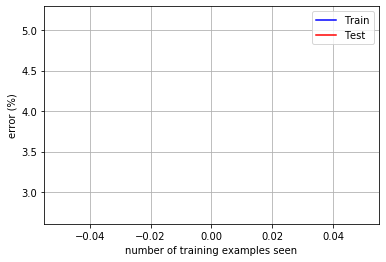

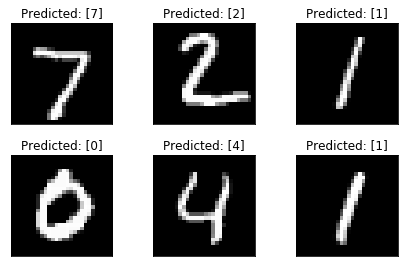

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))
  
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

With Learning Rate = 0.9


Test set: Average loss: 6.1172, Accuracy: 905/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 5.565647
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.385548
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.352385
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.377412
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.308119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.254072
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.396286
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.376013
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.316945
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.346944
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.319668
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.337223
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.315707
Train Epoch: 1 [16640/60000 (28%)]	Loss: 2.352433
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.321725
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.305046
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.338316
Train Epoch: 1 [21760/60000 (36%)]	Loss: 2.276350
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.309142
Train E

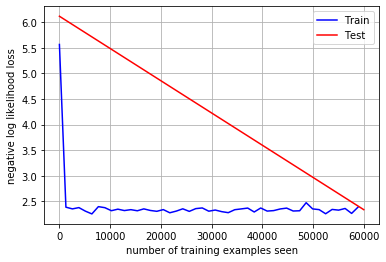

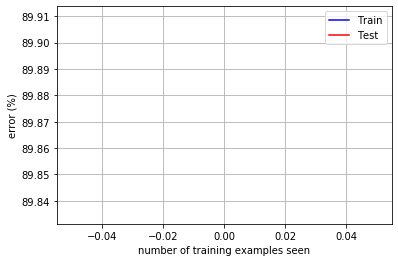

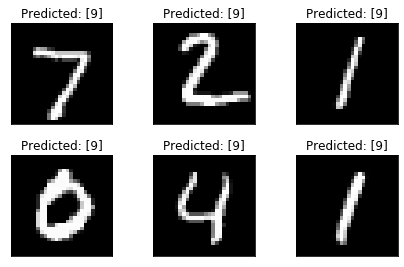

In [4]:
epochs = 1
batch_size = 64
learning_rate = 0.9
momentum = 0.9
weight_decay = 0 
log_interval = 20
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))
  
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

With weight decay = 0.5


Test set: Average loss: 3.2323, Accuracy: 1084/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.083210
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.201557
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.234657
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.919304
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.098419
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.208284
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.139350
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.225821
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.994890
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.142887
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.139907
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.352484
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.373596
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.167979
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.292983
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.123531
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.250789
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.264146
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.089597
Train

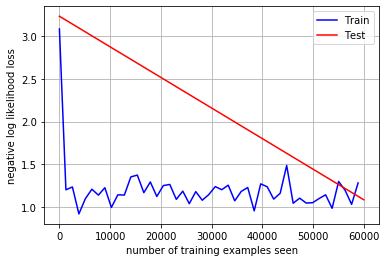

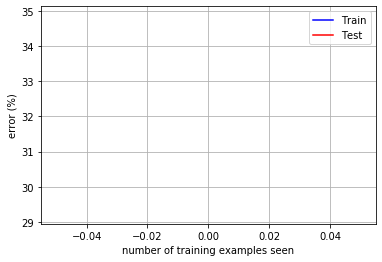

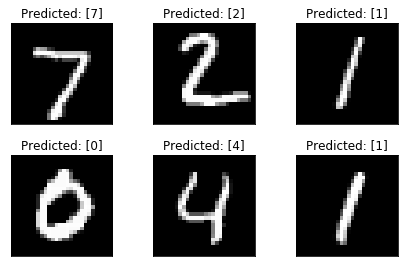

In [5]:
epochs = 1
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.5 
log_interval = 20
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))
  
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

With weight decay = 1


Test set: Average loss: 3.3319, Accuracy: 1515/10000 (15%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.999026
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.279467
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302654
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.301701
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.302603
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.299698
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.303059
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.301567
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.300264
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.302722
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.302862
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.302477
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.303549
Train Epoch: 1 [16640/60000 (28%)]	Loss: 2.303856
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.301203
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.298138
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.303111
Train Epoch: 1 [21760/60000 (36%)]	Loss: 2.301686
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.300786
Train

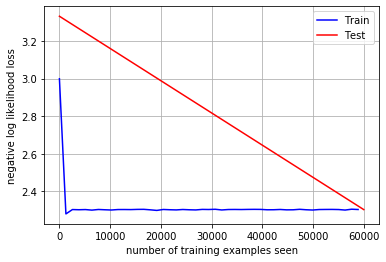

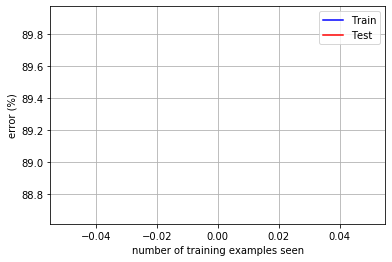

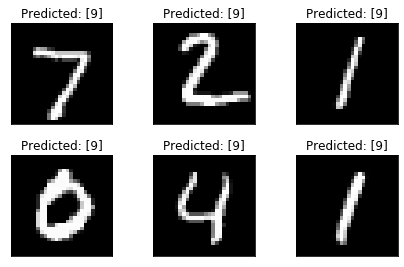

In [7]:
epochs = 1
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 1
log_interval = 20
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))
  
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

Epoches = 10


Test set: Average loss: 3.8593, Accuracy: 1338/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.221643
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291011
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301713
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.301613
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.302245
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.301902
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.303286
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.302777
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.303463
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.300344
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.301203
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.302930
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.301440
Train Epoch: 1 [16640/60000 (28%)]	Loss: 2.303289
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.303491
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.303705
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.301717
Train Epoch: 1 [21760/60000 (36%)]	Loss: 2.304069
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.301817
Train

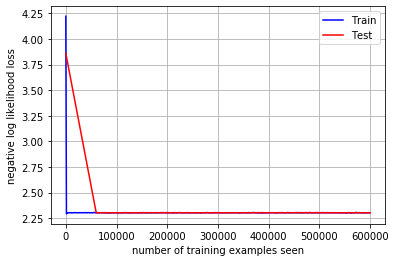

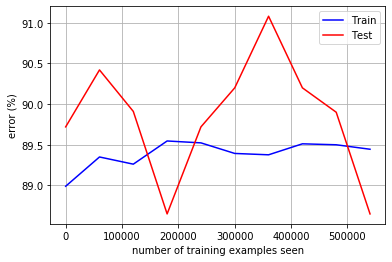

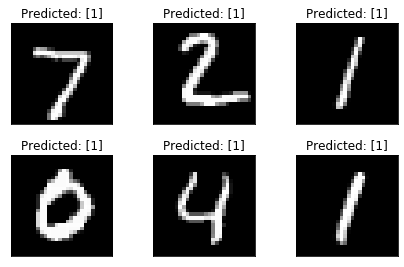

In [8]:
epochs = 10
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 1
log_interval = 20
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))
  
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

i) Learning Rate: We observe that higher the learning rate, the less accurate the model becomes. The accuracy reduces from 97% to only 10% as the learning rate in increased from 0.01 to 0.9. Although a lower learning rate makes the computation process slower, a large learning rate causes the model to overshoot the minimum and make it converge, or even diverge too quickly to a suboptimal solution.

ii) Weight Decay: The higher the weight decay, the less accurate the model becomes. With learning rate fixed as 0.01 (which gave most accuracy), as we increase the weight decay from 0 to 0.5 to 1, the accuracy reduces from 97% to 71% and to finally 10% respectively. Having a larger value for weight decay doesnt give a proper accuracy even after training it for 10 epochs as it makes the process more complex and overfits the data. 

1b. Using corrected model CNN2 on MNIST data

Epoch = 1


Test set: Average loss: 3.6209, Accuracy: 1122/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.726166
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.435993
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.243725
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.299884
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.170196
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.090200
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.084885
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.146526
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.027444
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.138746
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.072426
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.076243
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.111380
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.122653
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.030897
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.088638
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.197791
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.130564
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.054316
Train

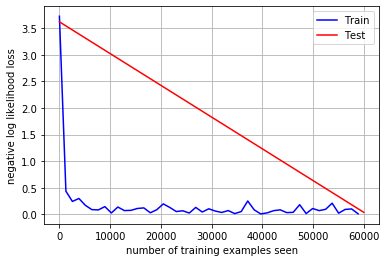

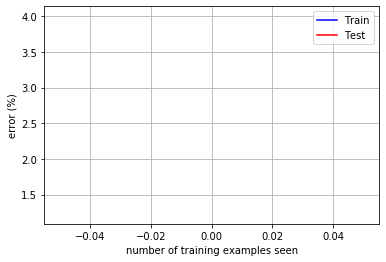

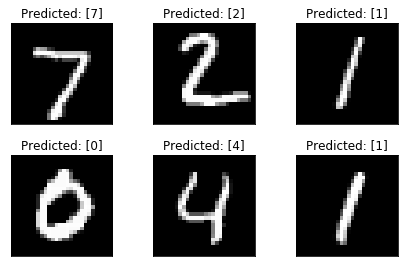

In [17]:
epochs = 1
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 0 
log_interval = 20
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))
  
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN2().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

1c. Computing mean and standard deviation of Fashion MNIST dataset and using that to normalize  the data in dataloader. Computing performance of model CNN2 on Fashion MNIST.

In [13]:
#compute mean and standard deviation of mnist dataset
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.FashionMNIST(root = "./data", train=True, download=True, transform=train_transform)
mean = (train_set.train_data.float().mean())/255#0.2860
#mean = np.mean(train_set)
std = (train_set.train_data.float().std())/255#0.3530
print ('mean', mean)
print ('standard deviation', std)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


mean tensor(0.2860)
standard deviation tensor(0.3530)



Test set: Average loss: 3.1781, Accuracy: 1079/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.007157
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.556039
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.576136
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.883283
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.444537
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.373226
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.392507
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.539918
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.340388
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.449394
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.379865
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.264616
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.377572
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.449558
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.460757
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.425775
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.509439
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.535125
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.549987
Train

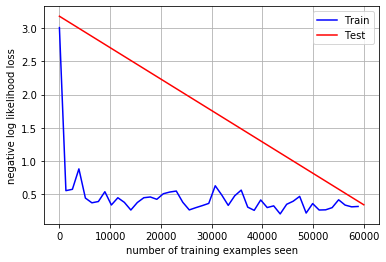

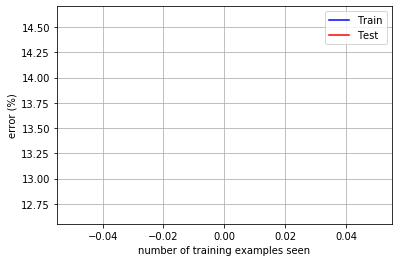

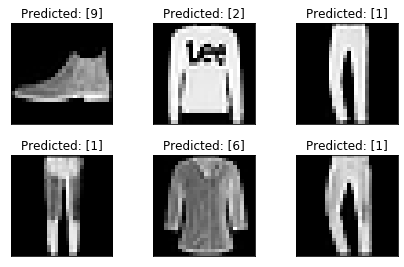

In [16]:
#Applying cnn2 on Fashion MNIST dataset
epochs = 1
batch_size = 64
learning_rate = 0.01# TODO
momentum = 0.9
weight_decay = 0 # TODO
log_interval = 20

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ]))
    test_data = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN2().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

1d. Applying CNN3 on Fashion MNIST dataset and comparing its accuracy with that of CNN2


Test set: Average loss: 2.5082, Accuracy: 1686/10000 (17%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.584574
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.718784
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.506651
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.426137
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.668294
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.633139
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.540921
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.395861
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.724189
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.374888
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.386499
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.449008
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.455371
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.472200
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.348155
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.535486
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.412165
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.300508
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.403065
Train

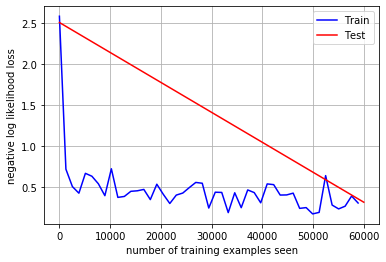

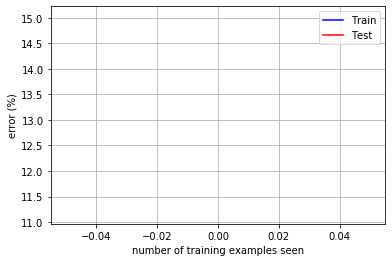

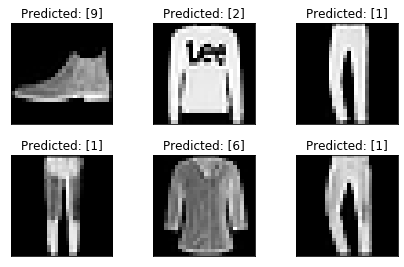

In [26]:
#Applying CNN3 on Fashion MNIST dataset
epochs = 1
batch_size = 64
learning_rate = 0.01# TODO
momentum = 0.9
weight_decay = 0 # TODO
log_interval = 20

class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(p=0.01)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ]))
    test_data = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN3().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

0it [00:00, ?it/s]

26427392it [00:02, 10610167.56it/s]                             


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 67552.67it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


4423680it [00:01, 2995075.44it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


8192it [00:00, 25861.81it/s]            


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!

Test set: Average loss: 3.1181, Accuracy: 306/10000 (3%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.120379
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.825911
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.561776
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.742705
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.421955
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.410313
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.510883
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.439284
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.456474
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.504727
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.417197
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.335671
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.412280
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.318000
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.446346
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.378426
Train Epoch: 1 [20480/6

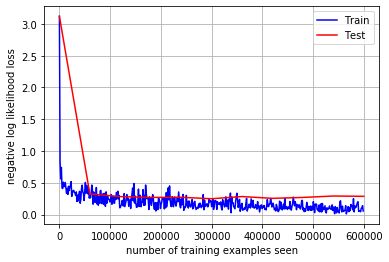

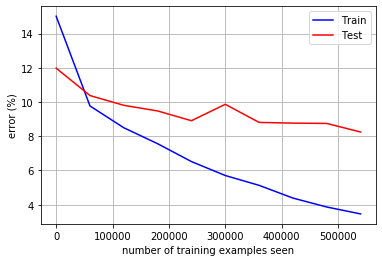

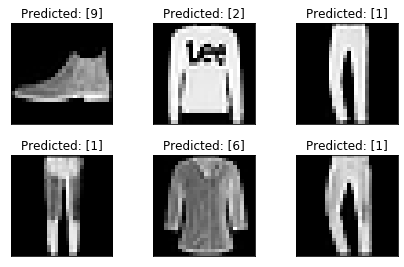

In [3]:
#Applying CNN3 on Fashion MNIST dataset with epoch 10
epochs = 10
batch_size = 64
learning_rate = 0.01# TODO
momentum = 0.9
weight_decay = 0 # TODO
log_interval = 20

class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(p=0.01)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ]))
    test_data = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN3().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')
	
if __name__ == '__main__':
    main()

With epoch = 1, CNN2 gives an accuracy of 87% whereas CNN 3 gives an accuracy of 89%. This improvement of 2% from 87% to 89% is due to the use of Dropout, which regularizes the algorithm further by randomly dropping out units, preventing complex co-adaptations on training data and reducing overfitting of the data.

With epoch = 10, CNN3 gives an accuracy of 92%. 

REFERENCES:
1. https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/
2. https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
3. https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch
4. https://stackoverflow.com/questions/56660546/how-to-select-parameters-for-nn-linear-layer-while-training-a-cnn 
5. https://discuss.pytorch.org/t/understanding-transform-normalize/21730
6. https://www.tensorflow.org/js/guide/models_and_layers
7. http://www.programmersought.com/article/6010108964/
8. https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10
9. https://machinelearning.wtf/terms/valid-convolution/
10. https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/
11. https://en.m.wikipedia.org/wiki/Dropout_(neural_networks)

